# Promoter Designer Evaluation

In [ ]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.functional import one_hot

from matplotlib import pyplot as plt
%matplotlib inline

import rpy2
import functools
import numpy as np
import pandas as pd
import pyBigWig
import tabix

import selene_sdk
from selene_sdk.utils import NonStrandSpecific
from selene_sdk.targets import Target

import sys
sys.path.append("../")
sys.path.append("../external")

from ddsm import * 
from sei import *
from selene_utils import *


In [ ]:
class ModelParameters:
    seifeatures_file = '../data/target.sei.names'
    seimodel_file = '../data/best.sei.model.pth.tar'

    ref_file = '../data/Homo_sapiens.GRCh38.dna.primary_assembly.fa'
    ref_file_mmap = '../data/Homo_sapiens.GRCh38.dna.primary_assembly.fa.mmap'
    tsses_file = '../data/FANTOM_CAT.lv3_robust.tss.sortedby_fantomcage.hg38.v4.tsv'

    fantom_files = [
                    "../data/agg.plus.bw.bedgraph.bw",
                    "../data/agg.minus.bw.bedgraph.bw"
                    ]

    fantom_blacklist_files = [
         "../data/fantom.blacklist8.plus.bed.gz",
         "../data/fantom.blacklist8.minus.bed.gz"
        ]

    diffusion_weights_file = 'steps400.cat4.speed_balance.time4.0.samples100000.pth'

    device = 'cuda'
    batch_size = 256
    num_workers = 4

    n_time_steps = 400

    random_order = False
    speed_balanced = True 

    ncat = 4

    num_epochs = 200

    lr = 5e-4
    

In [ ]:
v_one, v_zero, v_one_loggrad, v_zero_loggrad, timepoints = torch.load('steps400.cat4.speed_balance.time4.0.samples100000.pth')     
alpha = torch.FloatTensor([1.0, 1.0, 1.0])
beta = torch.FloatTensor([3.0, 2.0, 1.0])
torch.set_default_dtype(torch.float32)

max_time = timepoints[-1].item() 
min_time = timepoints[0].item()
n_time_steps = timepoints.shape[0]

In [ ]:
class GenomicSignalFeatures(Target):
    """
    #Accept a list of cooler files as input.
    """
    def __init__(self, input_paths, features, shape, blacklists=None, blacklists_indices=None, 
        replacement_indices=None, replacement_scaling_factors=None):
        """
        Constructs a new `GenomicFeatures` object.
        """
        self.input_paths = input_paths
        self.initialized = False
        self.blacklists_file = blacklists
        self.blacklists_indices = blacklists_indices
        self.replacement_indices = replacement_indices
        self.replacement_scaling_factors = replacement_scaling_factors

        self.n_features = len(features)
        self.feature_index_dict = dict(
            [(feat, index) for index, feat in enumerate(features)])
        self.shape = (len(input_paths), *shape)

    def get_feature_data(self, chrom, start, end, nan_as_zero=True, feature_indices=None):
        if not self.initialized:
            self.data = [pyBigWig.open(path) for path in self.input_paths]
            if self.blacklists_file is not None:
                self.blacklists = [tabix.open(blacklist) for blacklist in self.blacklists_file]
            self.initialized=True

        if feature_indices is None:
            feature_indices = np.arange(len(self.data))

        wigmat = np.zeros((len(feature_indices), end - start), dtype=np.float32)
        for i in feature_indices:
            try:
                wigmat[i, :] = self.data[i].values(chrom, start, end, numpy=True)
            except:
                print(chrom, start, end, self.input_paths[i], flush=True)
                raise
        
        if self.blacklists is not None:
            if self.replacement_indices is None:
                if self.blacklists_indices is not None:
                    for blacklist, blacklist_indices in zip(self.blacklists, self.blacklists_indices):
                        for _, s, e in blacklist.query(chrom, start, end):
                            wigmat[blacklist_indices, np.fmax(int(s)-start,0): int(e)-start] = 0
                else:
                    for blacklist in self.blacklists:
                        for _, s, e in blacklist.query(chrom, start, end):
                            wigmat[:, np.fmax(int(s)-start,0): int(e)-start] = 0
            else:
                for blacklist, blacklist_indices, replacement_indices, replacement_scaling_factor in zip(self.blacklists, self.blacklists_indices, self.replacement_indices, self.replacement_scaling_factors):
                    for _, s, e in blacklist.query(chrom, start, end):
                        wigmat[blacklist_indices, np.fmax(int(s)-start,0): int(e)-start] = wigmat[replacement_indices, np.fmax(int(s)-start,0): int(e)-start] * replacement_scaling_factor

        if nan_as_zero:
            wigmat[np.isnan(wigmat)]=0
        return wigmat

    
class TSSDatasetS(Dataset):
    def __init__(self, config, seqlength=1024, split="train", n_tsses=100000, rand_offset=0):
        self.shuffle = False

        self.genome = MemmapGenome(
            input_path=config.ref_file,
            memmapfile=config.ref_file_mmap,
            blacklist_regions='hg38'
        )
        self.tfeature = GenomicSignalFeatures(
            config.fantom_files,
            ['cage_plus', 'cage_minus'],
            (2000,),
            config.fantom_blacklist_files
        )

        self.tsses = pd.read_table(config.tsses_file, sep='\t')
        self.tsses = self.tsses.iloc[:n_tsses, :]

        self.chr_lens = self.genome.get_chr_lens()
        self.split = split
        if split == "train":
            self.tsses = self.tsses.iloc[~np.isin(self.tsses['chr'].values, ['chr8', 'chr9', 'chr10'])]
        elif split == "valid":
            self.tsses = self.tsses.iloc[np.isin(self.tsses['chr'].values, ['chr10'])]
        elif split == "test":
            self.tsses = self.tsses.iloc[np.isin(self.tsses['chr'].values, ['chr8', 'chr9'])]
        else:
            raise ValueError
        self.rand_offset = rand_offset
        self.seqlength = seqlength

    def __len__(self):
        return self.tsses.shape[0]

    def __getitem__(self, tssi):
        chrm, pos, strand = self.tsses['chr'].values[tssi], self.tsses['TSS'].values[tssi], self.tsses['strand'].values[
            tssi]
        offset = 1 if strand == '-' else 0

        offset = offset + np.random.randint(-self.rand_offset, self.rand_offset + 1)
        seq = self.genome.get_encoding_from_coords(chrm, pos - int(self.seqlength / 2) + offset,
                                                   pos + int(self.seqlength / 2) + offset, strand)

        signal = self.tfeature.get_feature_data(chrm, pos - int(self.seqlength / 2) + offset,
                                                pos + int(self.seqlength / 2) + offset)
        if strand == '-':
            signal = signal[::-1, ::-1]
        return np.concatenate([seq, signal.T], axis=-1).astype(np.float32)

    def reset(self):
        np.random.seed(0)

In [ ]:
class Dense(nn.Module):
    """
    A fully connected layer that reshapes outputs to feature maps.
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.dense = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.dense(x)[...]

    
class ScoreNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, embed_dim=256, time_dependent_weights=None, time_step=0.01):
    """
    Initialize a time-dependent score-based network.
    Args:
      marginal_prob_std: A function that takes time t and gives the standard
      deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    
    n=256
    self.linear = nn.Conv1d(5, n, kernel_size=9, padding=4)
    self.blocks = nn.ModuleList([nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, dilation=4, padding=16),
                nn.Conv1d(n, n, kernel_size=9, dilation=16, padding=64),
                nn.Conv1d(n, n, kernel_size=9, dilation=64, padding=256),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, dilation=4, padding=16),
                nn.Conv1d(n, n, kernel_size=9, dilation=16, padding=64),
                nn.Conv1d(n, n, kernel_size=9, dilation=64, padding=256),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, dilation=4, padding=16),
                nn.Conv1d(n, n, kernel_size=9, dilation=16, padding=64),
                nn.Conv1d(n, n, kernel_size=9, dilation=64, padding=256),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, padding=4),
                nn.Conv1d(n, n, kernel_size=9, dilation=4, padding=16),
                nn.Conv1d(n, n, kernel_size=9, dilation=16, padding=64),
                nn.Conv1d(n, n, kernel_size=9, dilation=64, padding=256)])



    self.denses = nn.ModuleList([Dense(embed_dim, n) for _ in range(20)])
    self.norms = nn.ModuleList([nn.GroupNorm(1,n) for _ in range(20)])

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    self.relu = nn.ReLU()
    self.softplus = nn.Softplus()
    self.scale = nn.Parameter(torch.ones(1))
    self.final =  nn.Sequential(nn.Conv1d(n, n, kernel_size=1),
                                nn.GELU(),
                                nn.Conv1d(n, 4, kernel_size=1))
    self.register_buffer("time_dependent_weights", time_dependent_weights)
    self.time_step = time_step
    
  def forward(self, x, t, t_ind=None, return_a=False):
    # Obtain the Gaussian random feature embedding for t
    # embed: [N, embed_dim]
    embed = self.act(self.embed(t/2))

    # Encoding path
    # x: NLC -> NCL
    out = x.permute(0, 2, 1)
    out = self.act(self.linear(out))
    
    #pos encoding
    for block, dense, norm in zip(self.blocks, self.denses, self.norms):
        h = self.act(block(norm(out + dense(embed)[:,:,None])))
        if h.shape == out.shape:
            out = h + out
        else:
            out = h

    
    out = self.final(out)
    out = out.permute(0, 2, 1)
    if self.time_dependent_weights is not None:
        t_step = (t/self.time_step)-1
        w0 = self.time_dependent_weights[t_step.long()]
        w1 = self.time_dependent_weights[torch.clip(t_step+1,max=len(self.time_dependent_weights)-1).long()]
        out = out * (w0 + (t_step-t_step.floor())*(w1-w0))[:,None,None]

    out = out - out.mean(axis=-1, keepdims=True)
    return out



In [ ]:
config = ModelParameters() 

C = config.ncat 
device = config.device 
n_time_steps = config.n_time_steps 
random_order = config.random_order
speed_balanced = config.speed_balanced

sb = UnitStickBreakingTransform()

train_set = TSSDatasetS(config, n_tsses=40000, rand_offset=10)
data_loader = DataLoader(train_set, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers)

time_dependent_cums = torch.zeros(n_time_steps).to(device)
time_dependent_counts = torch.zeros(n_time_steps).to(device)

avg_loss = 0.
num_items = 0
for i, x in enumerate(data_loader):
    x = x[...,:4]
    random_t = torch.randint(0, n_time_steps, (x.shape[0],))
    
    order = np.random.permutation(np.arange(C))
    #
    if random_order:
        #perturbed_x, perturbed_x_grad = diffusion_fast_flatdirichlet(x[...,order], random_t, v_one, v_one_loggrad)
        perturbed_x, perturbed_x_grad = diffusion_factory(x[...,order], random_t,  v_one, v_zero,v_one_loggrad, v_zero_loggrad, alpha, beta)
        perturbed_x = perturbed_x[..., np.argsort(order)]
        perturbed_x_grad = perturbed_x_grad[..., np.argsort(order)]
    else:
        #perturbed_x, perturbed_x_grad = diffusion_fast_flatdirichlet(x, random_t, v_one, v_one_loggrad)
        perturbed_x, perturbed_x_grad = diffusion_factory(x, random_t,  v_one, v_zero,v_one_loggrad, v_zero_loggrad, alpha, beta)
    perturbed_x = perturbed_x.to(device)    
    perturbed_x_grad = perturbed_x_grad.to(device)
    random_t = random_t.to(device)
    perturbed_v = sb._inverse(perturbed_x)

    order = np.random.permutation(np.arange(C))
    if random_order:
        perturbed_v = sb._inverse(perturbed_x[..., order], prevent_nan=True).detach()
    else:
        perturbed_v = sb._inverse(perturbed_x, prevent_nan=True).detach()


    time_dependent_counts[random_t] += 1
    if speed_balanced:
        s = 2/(torch.ones(C-1, device=device)+torch.arange(C-1,0,-1, device=device).float())
    else:
        s = torch.ones(C-1, device=device)
        
    if random_order:
        time_dependent_cums[random_t] +=  (perturbed_v*(1-perturbed_v) * s[(None,)*(x.ndim-1)] * (gx_to_gv(perturbed_x_grad[...,order],perturbed_x[...,order]))**2).view(x.shape[0],-1).mean(dim=1).detach()
    else:
        time_dependent_cums[random_t] +=  (perturbed_v*(1-perturbed_v) * s[(None,)*(x.ndim-1)] * (gx_to_gv(perturbed_x_grad,perturbed_x))**2).view(x.shape[0],-1).mean(dim=1).detach()

time_dependent_weights =  time_dependent_cums / time_dependent_counts
time_dependent_weights = time_dependent_weights / time_dependent_weights.mean()


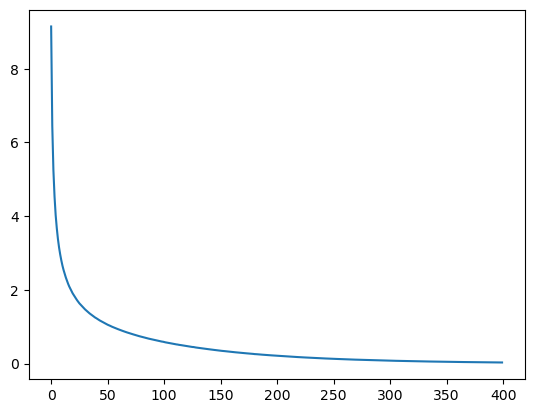

In [8]:
plt.plot(torch.sqrt(time_dependent_weights.cpu()))

In [9]:
sei = nn.DataParallel(NonStrandSpecific(Sei(4096, 21907)))
sei.load_state_dict(torch.load('../data/best.sei.model.pth.tar', map_location='cpu')['state_dict'])
sei.cuda()

seifeatures = pd.read_csv('../data/target.sei.names', sep='|', header=None)

In [ ]:
score_model = nn.DataParallel(ScoreNet(time_dependent_weights=torch.sqrt(time_dependent_weights)))
score_model.load_state_dict(torch.load('../best_model_weights/promoter_designer/promoter.cond.4l.pth'))

score_model.cuda() 
score_model.eval()

In [11]:
sampler = Euler_Maruyama_sampler

In [105]:
test_set = TSSDatasetS(config, split='test',n_tsses=40000, rand_offset=0)
test_data_loader = DataLoader(test_set, batch_size=config.batch_size, shuffle=False, num_workers=0)
test_datasets = []
for x in test_data_loader:
    test_datasets.append(x)

In [112]:
#generate sequence samples
torch.set_default_dtype(torch.float32)

allsamples = []
for t in test_datasets:
    samples=[]
    for i in range(5):
        score_model.eval()
        samples.append(sampler(score_model,
                          (1024,4),
                          batch_size=t.shape[0],
                          max_time=max_time,
                          min_time=min_time,
                          time_dilation=1,
                          num_steps=100, 
                          eps=1e-5,
                          speed_balanced=speed_balanced,
                          device=device,
                          concat_input = t[:,:,4:5].cuda()).cpu().detach().numpy())
    allsamples.append(samples)

100%|██████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.90it/s]


In [ ]:
#with time-dilation
torch.set_default_dtype(torch.float32)

allsamples2x = []
for t in test_datasets:
    samples=[]
    for i in range(5):
        score_model.eval()
        samples.append(Euler_Maruyama_sampler(score_model,
                          (1024,4),
                          batch_size=t.shape[0],
                          max_time=max_time,
                          min_time=min_time,
                          time_dilation=2,
                          time_dilation_start_time=1,
                          num_steps=200,
                          eps=1e-5,
                          speed_balanced=speed_balanced,
                          device=device,
                          concat_input = t[:,:,4:5].cuda()).cpu().detach().numpy())
    allsamples2x.append(samples)

In [ ]:
#with time-dilatio
torch.set_default_dtype(torch.float32)

allsamples4x = []
for t in test_datasets:
    samples=[]
    for i in range(5):
        score_model.eval()
        samples.append(Euler_Maruyama_sampler(score_model,
                          (1024,4),
                          batch_size=t.shape[0],
                          max_time=max_time,
                          min_time=min_time, 
                          time_dilation=4,
                          time_dilation_start_time=1,
                          num_steps=400,
                          eps=1e-5, 
                          speed_balanced=speed_balanced,
                          device=device,
                          concat_input = t[:,:,4:5].cuda()).cpu().detach().numpy())
    allsamples4x.append(samples)

In [113]:
allsamples = np.concatenate(allsamples, axis=1)

In [17]:
allsamples2x = np.concatenate(allsamples2x, axis=1)

In [30]:
allsamples4x = np.concatenate(allsamples4x, axis=1)

In [114]:
testseqs = np.concatenate(test_datasets, axis=0)[:,:,:4]

In [115]:
allsamples.shape

(5, 2915, 1024, 4)

In [116]:
testseqs.shape

(2915, 1024, 4)

In [19]:
np.save(arr=allsamples, file='allsamples.npy')
np.save(arr=allsamples2x, file='allsamples.tdilation2x_tdsf1.npy')
np.save(arr=allsamples4x, file='allsamples.tdilation4x_tdsf1.npy')

In [2]:
allsamples = np.load('allsamples.npy')
allsamples2x = np.load('allsamples.tdilation2x_tdsf1.npy')
allsamples4x = np.load('allsamples.tdilation4x_tdsf1.npy')

In [20]:
allsamples_pred = np.zeros((5, 2915, 21907))
for j in range(5):
    for i in range(int(allsamples[j].shape[0]/128)):
        seq = 1.0* (allsamples[j][i*128:(i+1)*128] > 0.5)
        allsamples_pred[j,i*128:(i+1)*128] =  sei(torch.cat([torch.ones((seq.shape[0],4,1536))*0.25, torch.FloatTensor(seq).transpose(1,2), 
                   torch.ones((seq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()
    seq = allsamples[j][-128:]
    allsamples_pred[j, -128:] =  sei(torch.cat([torch.ones((seq.shape[0],4,1536))*0.25, torch.FloatTensor(seq).transpose(1,2), 
                   torch.ones((seq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()


In [21]:
allsamples_pred2x = np.zeros((5, 2915, 21907))
for j in range(5):
    for i in range(int(allsamples2x[j].shape[0]/128)):
        seq = 1.0* (allsamples2x[j][i*128:(i+1)*128] > 0.5)
        allsamples_pred2x[j,i*128:(i+1)*128] =  sei(torch.cat([torch.ones((seq.shape[0],4,1536))*0.25, torch.FloatTensor(seq).transpose(1,2), 
                   torch.ones((seq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()
    seq = allsamples2x[j][-128:]
    allsamples_pred2x[j, -128:] =  sei(torch.cat([torch.ones((seq.shape[0],4,1536))*0.25, torch.FloatTensor(seq).transpose(1,2), 
                   torch.ones((seq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()


In [33]:
allsamples_pred4x = np.zeros((5, 2915, 21907))
for j in range(5):
    for i in range(int(allsamples4x[j].shape[0]/128)):
        seq = 1.0* (allsamples4x[j][i*128:(i+1)*128] > 0.5)
        allsamples_pred4x[j,i*128:(i+1)*128] =  sei(torch.cat([torch.ones((seq.shape[0],4,1536))*0.25, torch.FloatTensor(seq).transpose(1,2), 
                   torch.ones((seq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()
    seq = allsamples4x[j][-128:]
    allsamples_pred4x[j, -128:] =  sei(torch.cat([torch.ones((seq.shape[0],4,1536))*0.25, torch.FloatTensor(seq).transpose(1,2), 
                   torch.ones((seq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()


In [110]:
with torch.no_grad():
    testseqs_pred = np.zeros((2915, 21907))
    for i in range(int(testseqs.shape[0]/128)):
        testseq = testseqs[i*128:(i+1)*128]
        testseqs_pred[i*128:(i+1)*128] =  sei(torch.cat([torch.ones((testseq.shape[0],4,1536))*0.25, torch.FloatTensor(testseq).transpose(1,2), 
                   torch.ones((testseq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()
    testseq = testseqs[-128:]
    testseqs_pred[-128:] =  sei(torch.cat([torch.ones((testseq.shape[0],4,1536))*0.25, torch.FloatTensor(testseq).transpose(1,2), 
                   torch.ones((testseq.shape[0],4,1536))*0.25], 2).cuda()).cpu().detach().numpy()


In [117]:
testseqs_predh3k4me3 = testseqs_pred[:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=1)

In [119]:
exp=(10**np.concatenate(test_datasets, axis=0)[:,12:-12,4]-1).sum(axis=-1)

In [118]:
allsamples_predh3k4me3 = allsamples_pred[:,:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=-1)

In [120]:
exp.shape

(2915,)

In [121]:
testseqs_predh3k4me3.shape

(2915,)

In [29]:
allsamples2x_predh3k4me3 = allsamples_pred2x[:,:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=-1)

In [40]:
allsamples4x_predh3k4me3 = allsamples_pred4x[:,:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=-1)

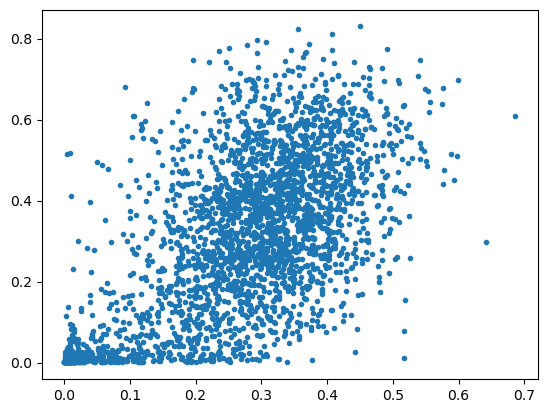

In [25]:
plt.plot(allsamples_pred[:,:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=-1).mean(0),
        testseqs_pred[:,seifeatures[1].str.strip().values=='H3K4me3'].mean(axis=-1),'.')

In [122]:
acc = []
for i in range(5):
    acc.append(((allsamples_predh3k4me3[i] - testseqs_predh3k4me3)**2).mean())
np.mean(acc), np.std(acc)/np.sqrt(4)

(0.038815078787929294, 0.0003888892166261333)

In [31]:
acc = []
for i in range(5):
    acc.append(((allsamples2x_predh3k4me3[i] - testseqs_predh3k4me3)**2).mean())
np.mean(acc), np.std(acc)/np.sqrt(4)

(0.03515690028053534, 0.00044875304970907386)

In [ ]:
acc = []
for i in range(5):
    acc.append(((allsamples4x_predh3k4me3[i] - testseqs_predh3k4me3)**2).mean())
np.mean(acc), np.std(acc)/np.sqrt(4)

In [ ]:
%load_ext rpy2.ipython

In [123]:
%%R 
require(scales)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(1, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}
scale_fill_Publication <- function(...){
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}
scale_colour_Publication <- function(...){
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

In [ ]:
%%R -i testseqs_predh3k4me3,allsamples_predh3k4me3,exp -w 10 -h 6 --unit in --res 300
require(ggplot2)

cutp <- function(x){
    cut(x, breaks=c(quantile(x, probs = seq(0, 1, by = 0.10))), include.lowest = T,
    labels=c("0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"))
}

print(table(cutp(log10(1+exp))))
plotdata = rbind(data.frame(x=cutp(log10(1+exp)), y=testseqs_predh3k4me3/0.004138, type='Human genome sequence'),
      data.frame(x=cutp(log10(1+exp)), y=allsamples_predh3k4me3[1,]/0.004138, type='Designed sequence'))
p = ggplot(plotdata)+geom_boxplot(aes(x=x, y=y, fill=type),outlier.shape = NA)+
    ylab('Sequence promoter activity prediction \n (fold above baseline)') + xlab('Targeted promoter transcriptional activity for sequence generation (percentile)')+
    theme_Publication()+scale_fill_manual(values=c('gray','red'))+geom_hline(yintercept=1, linetype=2)
#ggsave('./figures/compare_seqs.pdf', device=cairo_pdf)
p


  0-10%  10-20%  20-30%  30-40%  40-50%  50-60%  60-70%  70-80%  80-90% 90-100% 
    292     291     292     291     292     291     291     292     291     292 


In [43]:
testseqs_scpred = testseqs_predh3k4me3
allsamples_scpred = allsamples_predh3k4me3
allsamples2x_scpred = allsamples2x_predh3k4me3

In [ ]:

%%R -i testseqs_scpred,allsamples_scpred,allsamples2x_scpred,exp -w 10 -h 6 --unit in --res 300
require(ggplot2)

cutp <- function(x){
    cut(x, breaks=c(quantile(x, probs = seq(0, 1, by = 0.10))), include.lowest = T,
    labels=c("0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"))
}

print(table(cutp(log10(1+exp))))
plotdata = rbind(data.frame(x=cutp(log10(1+exp)), y=testseqs_scpred/0.004138, type='Human genome sequence'),
      data.frame(x=rep(cutp(log10(1+exp)),each=5), y=as.numeric(allsamples_scpred)/0.004138, type='Designed sequence'),
       data.frame(x=rep(cutp(log10(1+exp)),each=5), y=as.numeric(allsamples2x_scpred)/0.004138, type='Designed sequence (2x time dilation)'))
p = ggplot(plotdata)+geom_boxplot(aes(x=x, y=y, fill=type),outlier.shape = NA)+
    ylab('Sequence promoter activity prediction \n (fold above baseline)') + xlab('Targeted promoter transcriptional activity for sequence generation (percentile)')+
    theme_Publication()+scale_fill_manual(values=c('gray','red','purple'))+geom_hline(yintercept=1, linetype=2)
#ggsave('./figures/compare_seqs2.pdf', device=cairo_pdf)
p


  0-10%  10-20%  20-30%  30-40%  40-50%  50-60%  60-70%  70-80%  80-90% 90-100% 
    292     291     292     291     292     291     291     292     291     292 


In [47]:
sample_bp = allsamples[0,:,:,:].mean(axis=0)
testseqs_bp = testseqs.mean(axis=0)

In [48]:
sample_bp2x = allsamples2x[0,:2915,:,:].mean(axis=0)

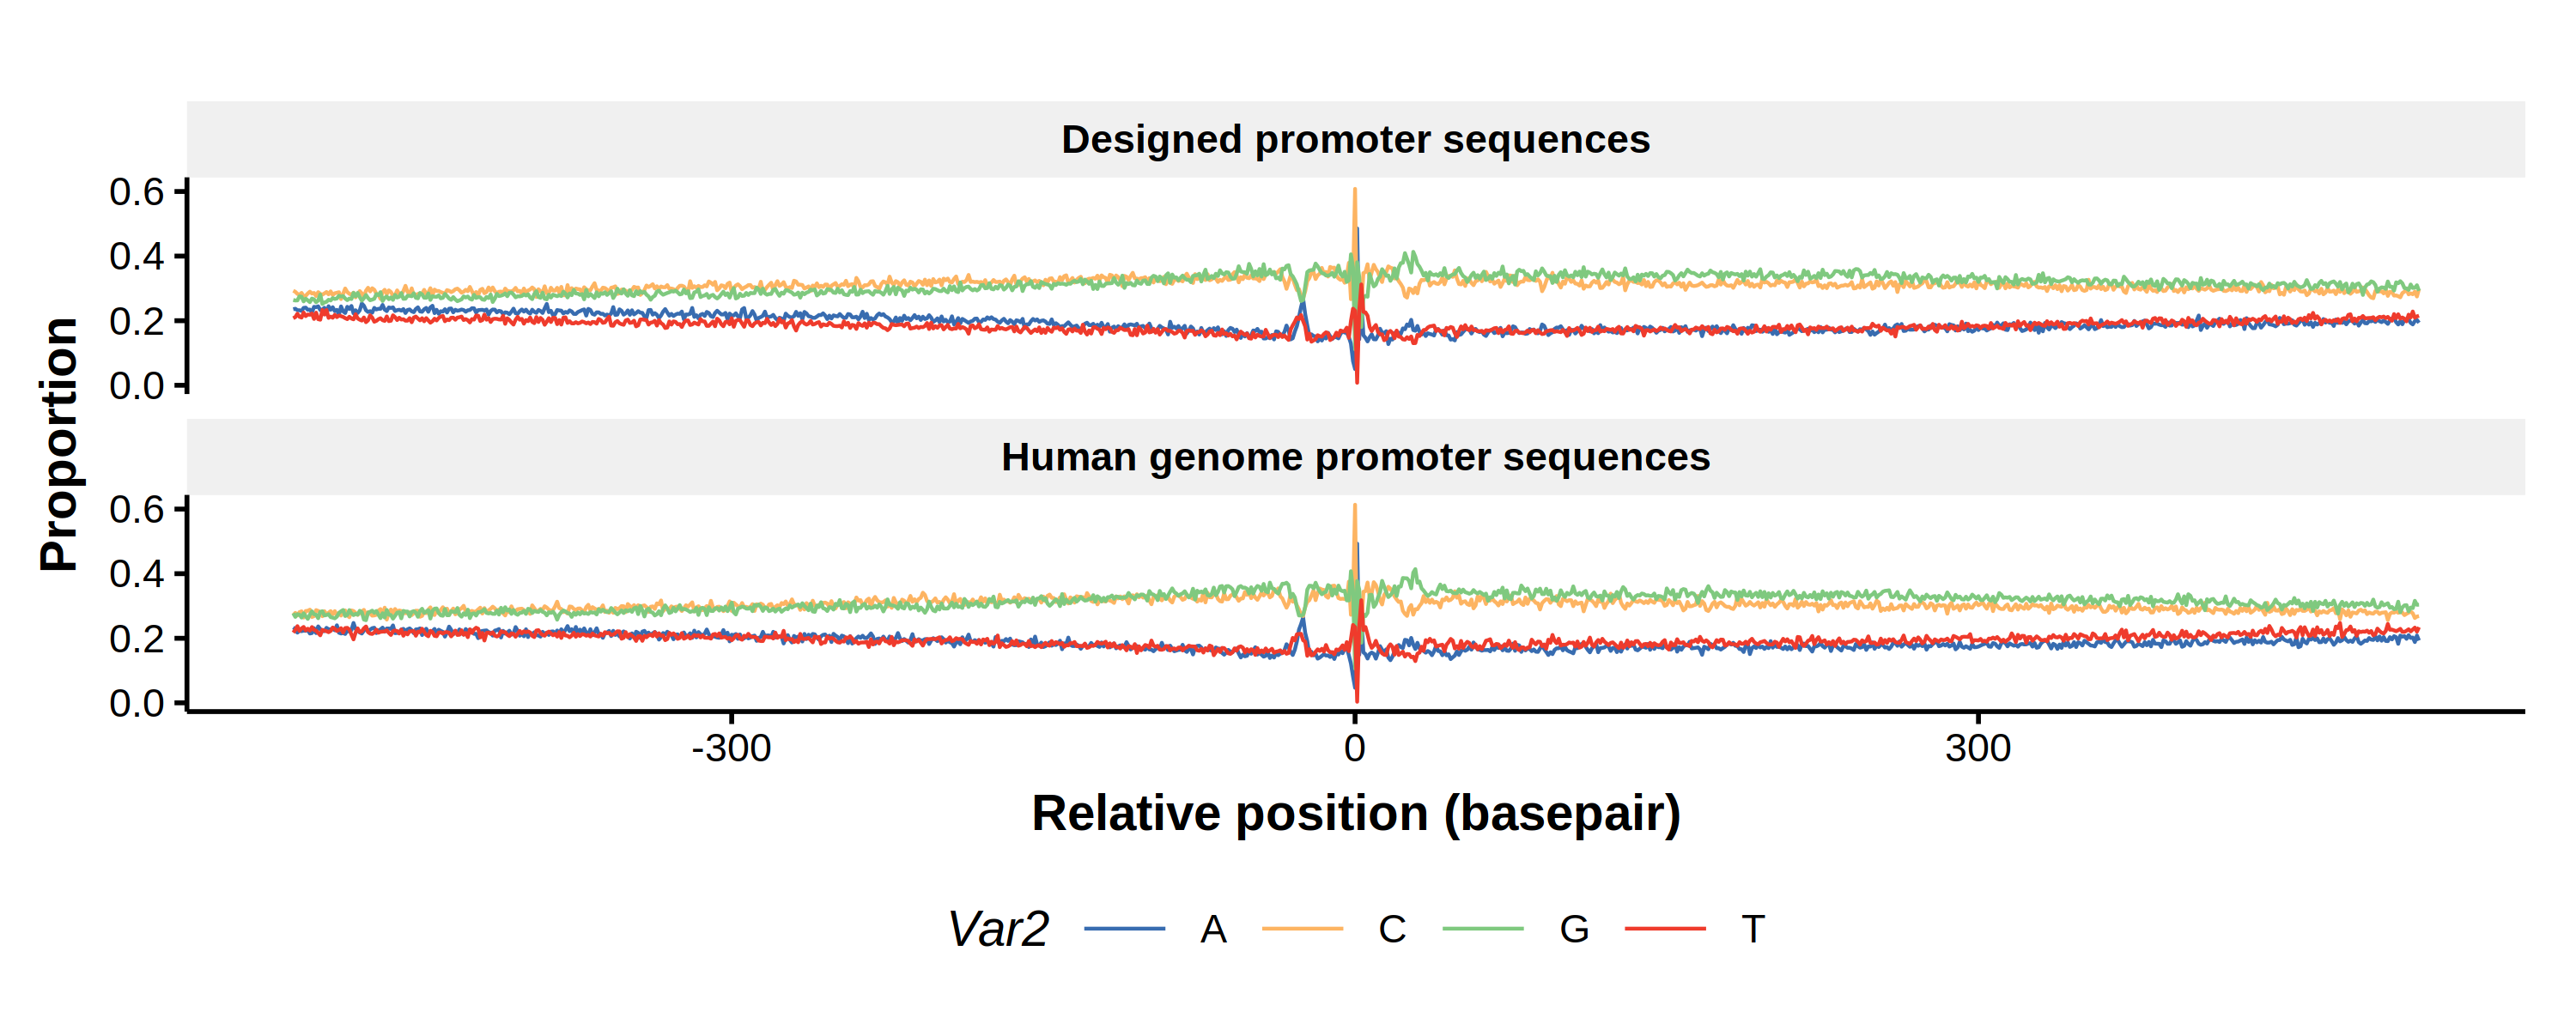

In [49]:
%%R -i sample_bp,testseqs_bp -w 10 -h 4 --unit in --res 300
require(ggplot2)
require(reshape2)
colnames(sample_bp) = c('A','C','G','T')
colnames(testseqs_bp) = c('A','C','G','T')
plotdata = rbind(cbind(melt(sample_bp),type='Designed promoter sequences'), 
                 cbind(melt(testseqs_bp),type='Human genome promoter sequences'))

p=ggplot(plotdata) + geom_line(aes(x=Var1-512, y=value, color=Var2))+theme_Publication()+scale_colour_Publication()+
    facet_wrap(~type,nrow=2)+xlab('Relative position (basepair)') + ylab('Proportion')
# ggsave('./figures/seqs_bp.pdf', device=cairo_pdf)
p

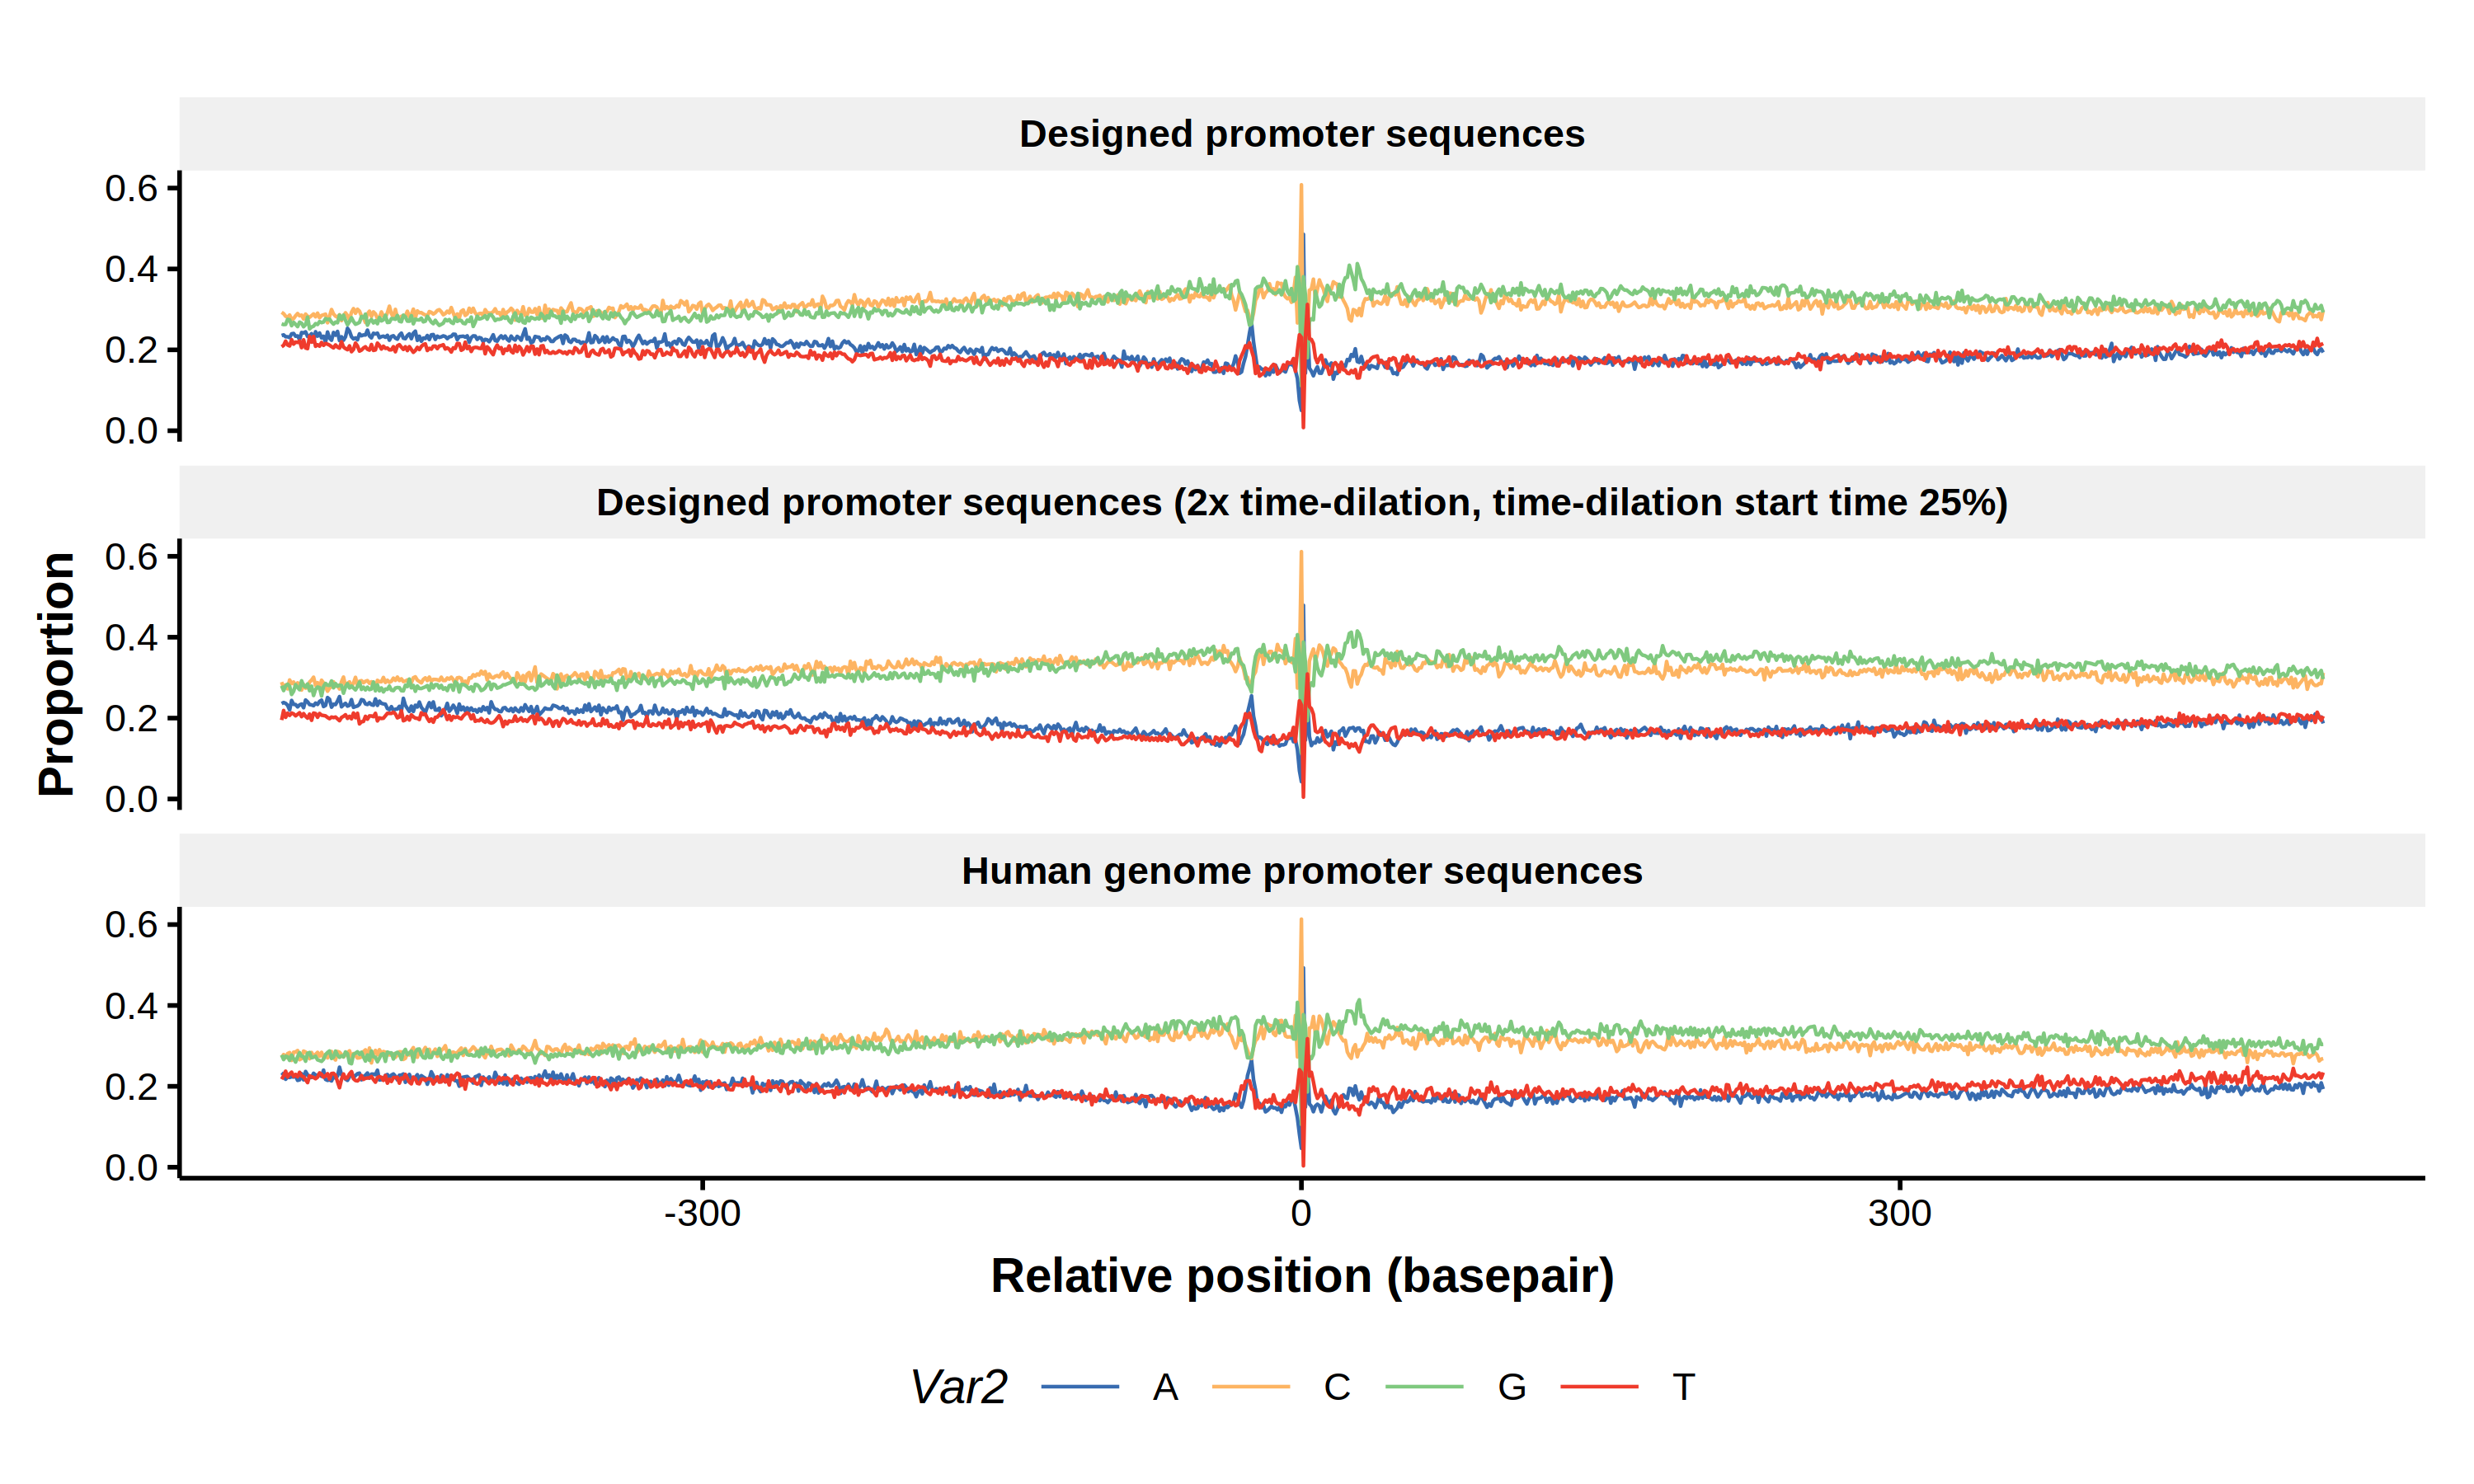

In [50]:
%%R -i sample_bp,sample_bp2x,testseqs_bp -w 10 -h 6 --unit in --res 300
require(ggplot2)
require(reshape2)
colnames(sample_bp) = c('A','C','G','T')
colnames(sample_bp2x) = c('A','C','G','T')
colnames(testseqs_bp) = c('A','C','G','T')
plotdata = rbind(cbind(melt(sample_bp),type='Designed promoter sequences'), 
                 cbind(melt(sample_bp2x),type='Designed promoter sequences (2x time-dilation, time-dilation start time 25%)'), 
                 cbind(melt(testseqs_bp),type='Human genome promoter sequences'))

p=ggplot(plotdata) + geom_line(aes(x=Var1-512, y=value, color=Var2))+theme_Publication()+scale_colour_Publication()+
    facet_wrap(~type,nrow=3)+xlab('Relative position (basepair)') + ylab('Proportion')
# ggsave('./figures/seqs_bp2.pdf', device=cairo_pdf)
p

In [ ]:
score_model.cuda()
score_model.eval()

all_bpds = 0.
all_items = 0

sb = UnitStickBreakingTransform()

logliks = []
loglikxs = []
qlogs  = []
all_bpds_l = []

for _ in range(10):
    cur_bpds = []
    for x in test_datasets:
        s = x[...,4:5]
        x = x[...,:4]

        perturbed_x, _ = diffusion_factory(x.cpu(), torch.zeros(x.shape[0]).long(),  v_one, v_zero,v_one_loggrad, v_zero_loggrad, alpha, beta)
        #perturbed_x, _ = diffusion_fast_flatdirichlet(x.cpu(), min_time, v_one, v_one_loggrad)

        perturbed_x = perturbed_x.to(device)
        x = x.to(device)
        v = sb._inverse(x, prevent_nan=False)
        perturbed_v = sb._inverse(perturbed_x, prevent_nan=False)

        z, loglik = ode_likelihood(perturbed_v, score_model, eps=1e-8, min_time=min_time, max_time=max_time,
                    device=device, alpha=None,beta=None, concat_input=s.cuda()) 
        N = np.prod(x.shape[1:-1]) 
        loglik = loglik / N
        loglikx = ( torch.log(torch.clip(perturbed_x, min=1e-8)) * (x==1)).sum(-1).mean(-1)

        torch.set_default_dtype(torch.float64)

        with torch.no_grad():
            qlog = jacobi_diffusion_density(v.double(), perturbed_v.double(), min_time, alpha.to(device), beta.to(device), order=1000).log()

        for i, (a,b) in enumerate(zip(alpha.to(device), beta.to(device))):
            B = Beta(a, b)
            nanmask = torch.isnan(qlog[...,i])
            qlog[..., i][nanmask] = B.log_prob(perturbed_v[...,i][nanmask].double())

        qlog = (qlog.sum(-1)+sb.log_abs_det_jacobian(perturbed_v)).float().mean(-1)

        #qlog and loglikx  does not depdend on the model, so this is presampled to speed things up
        #note this is only for this dataset and this setup
        torch.set_default_dtype(torch.float32)

        elbo = loglik + loglikx - qlog
        logliks.append(loglik.cpu().detach().numpy())
        loglikxs.append(loglikx.cpu().detach().numpy())
        qlogs.append(qlog.cpu().detach().numpy())

        bpd = -(elbo.cpu().detach().numpy()) / np.log(2)
        cur_bpds.append(-(elbo.cpu().detach().numpy()) / np.log(2))
        all_bpds += bpd.sum()
        all_items += bpd.shape[0]
        print("Average bits: {:5f}".format(all_bpds / all_items))
        print("Average nats: {:5f}".format(all_bpds / all_items *  np.log(2)))
        if np.isnan(all_bpds):
            break
    all_bpds_l.append(np.concatenate(cur_bpds, axis=0))


Number of function evaluations: 191
Average bits: 1.359026
Average nats: 0.942005
Number of function evaluations: 185
Average bits: 1.368120
Average nats: 0.948308
Number of function evaluations: 185
Average bits: 1.360587
Average nats: 0.943087
Number of function evaluations: 185
Average bits: 1.353737
Average nats: 0.938339
Number of function evaluations: 185
Average bits: 1.350626
Average nats: 0.936183
Number of function evaluations: 185
Average bits: 1.339858
Average nats: 0.928719
Number of function evaluations: 185
Average bits: 1.339804
Average nats: 0.928681
Number of function evaluations: 182
Average bits: 1.341645
Average nats: 0.929958
Number of function evaluations: 182
Average bits: 1.349110
Average nats: 0.935132
Number of function evaluations: 179
Average bits: 1.359493
Average nats: 0.942329
Number of function evaluations: 179
Average bits: 1.365473
Average nats: 0.946473
Number of function evaluations: 176
Average bits: 1.371190
Average nats: 0.950436
Number of functi

In [128]:
bpds1 = np.concatenate(bpds, axis=0)

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [133]:
print(bpds1.shape)
print(exp.shape)

(2915,)
(2915,)


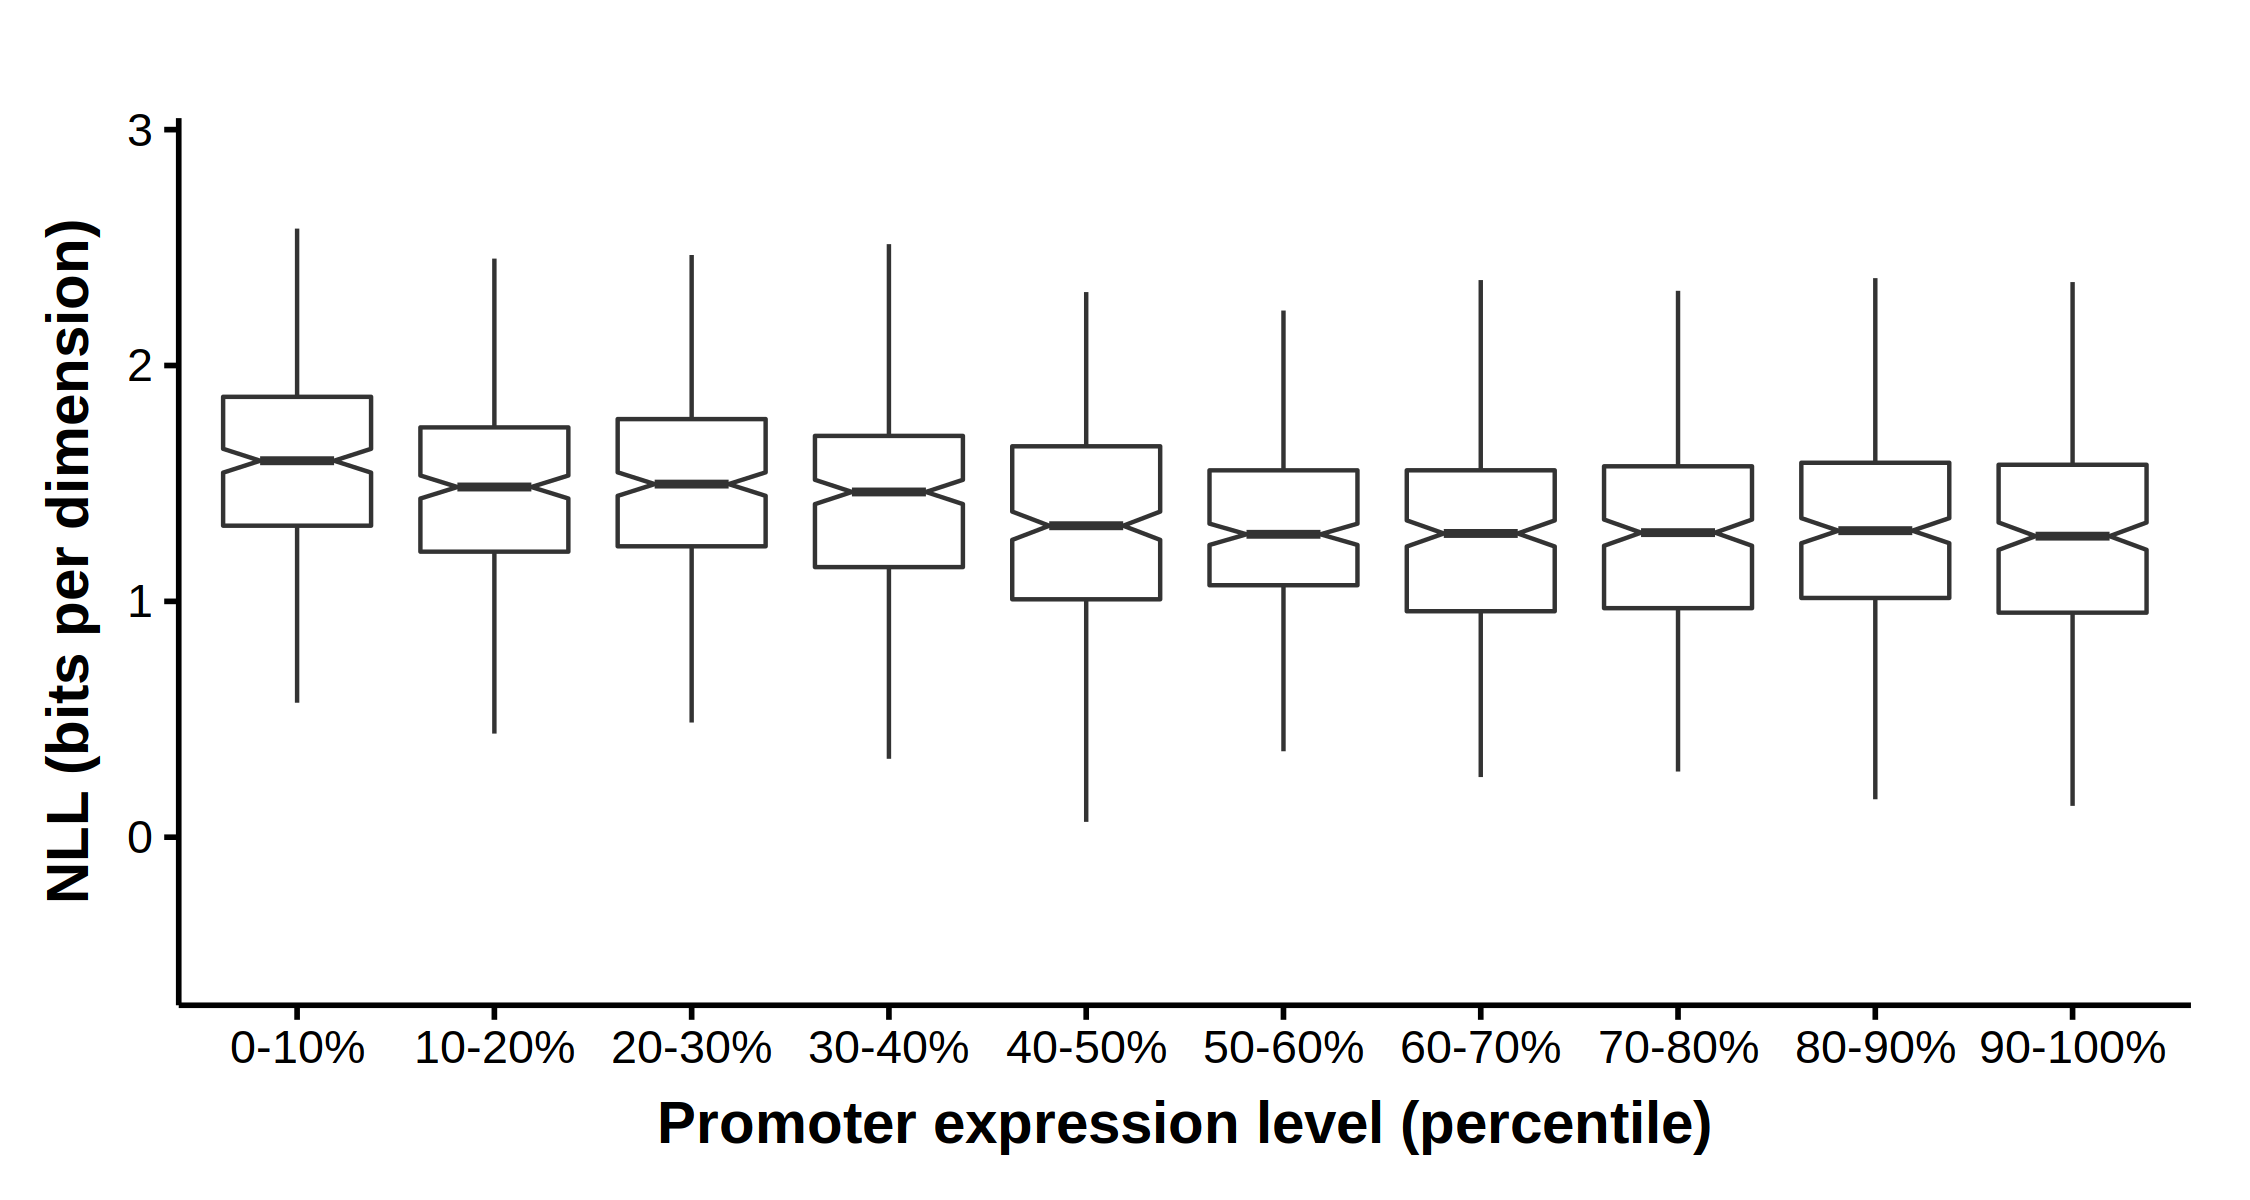

In [137]:
%%R -i exp,bpds1  -w 7.5 -h 4 --unit in --res 300
cutp <- function(x){
    cut(x, breaks=c(quantile(x, probs = seq(0, 1, by = 0.10))), include.lowest = T,
    labels=c("0-10%","10-20%","20-30%","30-40%","40-50%","50-60%","60-70%","70-80%","80-90%","90-100%"))
}
qplot(cutp(exp), bpds1, geom='boxplot', notch=T, outlier.shape=NA)+
    theme_Publication()+ylab('NLL (bits per dimension)')+xlab('Promoter expression level (percentile)')
# ggsave('./figures/seqs_nll.pdf', device=cairo_pdf)
